# Toy Problem

This notebook compares results from grid search, random search, and Bayesian search for a 1D problem on the first patient.

## Clinical Goals (Approved Plan)

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200

## Clinical Goals (Implemented)

idx | Roi | Type | Goal Criteria | AcceptanceLevel | Parameter Value
-|-|-|-|-|-|
0 | PTV | MinDvh | AtLeast | 4800 | 95
1 | PTV | MaxDose | AtMost | 6240 | 0
2 | SpinalCanal | MaxDvh | AtMost | 2080 | 0.67
3 | Lungs | MaxDvh | AtMost | 2000 | 10
4 | Heart | MaxDvh | AtMost | 2800 |  1.84
5 | ChestWall_L | MaxDvh | AtMost | 3000 | 2.04
6 | Rib | MaxDvh | AtMost | 3200 | 0.27

## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min DVH 4800 cGy to 95% volume | MinDvh | 4800 | 95 | 1
1 | PTV | Max Dose 6200 cGy | MaxDose | 6200 | 0 | 1
2 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
3 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1
4 | Heart | Max DVH 2800 cGy to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1

In [1]:
from importlib import reload
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble as ens
import sklearn.gaussian_process as gp

sys.path.append('../../src')
import plots

In [17]:
# Load results
funcs = pd.read_csv('funcs_toy.csv')
goals = pd.read_csv('goals.csv')

# Approved plan
dvh_approved = np.load('dvh_approved.npy', allow_pickle=True)
results_approved = pd.read_pickle('results_approved.npy')

# Grid search
pars_grid = pd.read_pickle('pars_grid.npy')
pars_grid = pars_grid[pars_grid['Sample'] < 25]
results_grid = pd.read_pickle('results_grid.npy')
results_grid = results_grid[results_grid['Sample'] < 25]
dvh_grid = np.load('dvh_0.npy', allow_pickle=True)

# Random search
x_rand = np.load('x_iters_rand.npy').squeeze()
fun_rand = np.load('func_vals_rand.npy')
dvh_rand = np.load('dvh_1.npy', allow_pickle=True)

# Bayesian search 
x_gp = np.load('x_iters_gp.npy').squeeze()
x_forest = np.load('x_iters_forest.npy').squeeze()
fun_gp = np.load('func_vals_gp.npy')
fun_forest = np.load('func_vals_forest.npy')
dvh_gp = np.load('dvh_2.npy', allow_pickle=True)
dvh_forest = np.load('dvh_3.npy', allow_pickle=True)
results = pd.read_pickle('results_toy.npy')

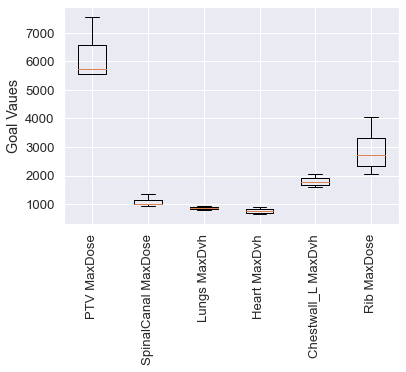

In [18]:
# Clinical goal results from grid search
plots.boxplot(goals[1:], results_grid, 'goals')

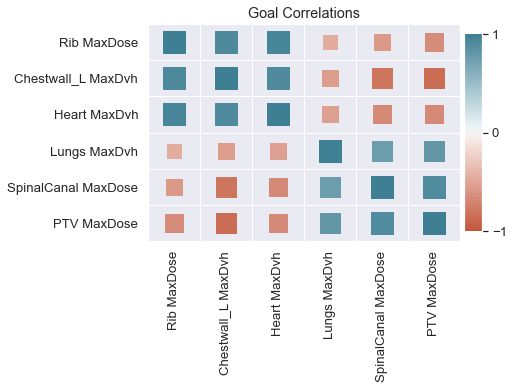

In [19]:
# Goal correlations from grid search
plots.corrplot(goals[1:], results_grid, title='Goal Correlations')

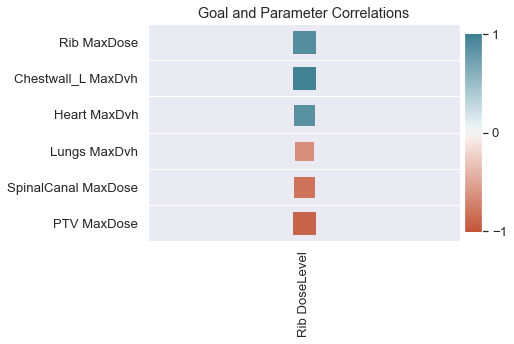

In [20]:
# Goal and parameters correlation from grid search
plots.corrplot(goals[1:], results_grid, funcs, pars_grid, 'Goal and Parameter Correlations')

In [21]:
# Compute penalty values for grid search
fun_grid = 0
x_grid, _ = plots.format_data(funcs, pars_grid, 'pars')
x_grid = x_grid[0].values
ydata, _ = plots.format_data(goals[1:], results_grid, 'goals')
for ii in range(len(ydata)):
    level = goals.iloc[ii+1]['AcceptanceLevel']
    fun_grid += (ydata[ii] - level)/level

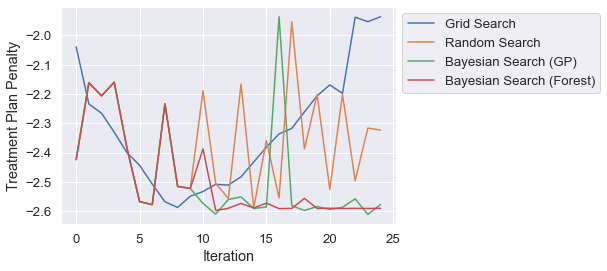

In [22]:
# Compare convergence of optimization methods
plt.plot(fun_grid)
plt.plot(fun_rand)
plt.plot(fun_gp)
plt.plot(fun_forest)
plt.xlabel('Iteration')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search (GP)', 'Bayesian Search (Forest)'],
           bbox_to_anchor=(1, 1));

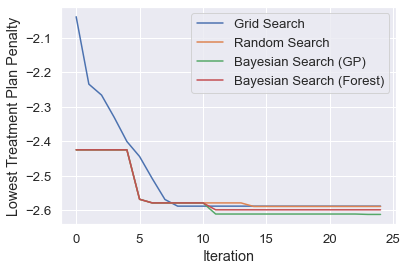

In [23]:
# Compare convergence of optimization methods
plt.plot(np.minimum.accumulate(fun_grid))
plt.plot(np.minimum.accumulate(fun_rand))
plt.plot(np.minimum.accumulate(fun_gp))
plt.plot(np.minimum.accumulate(fun_forest))
plt.xlabel('Iteration')
plt.ylabel('Lowest Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search (GP)', 'Bayesian Search (Forest)'],
           bbox_to_anchor=(1, 1));

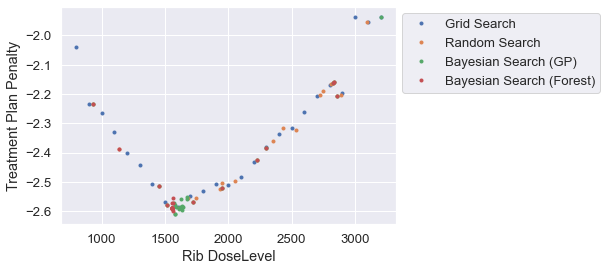

In [24]:
# Compare penalty value results
plt.plot(x_grid, fun_grid, '.')
plt.plot(x_rand, fun_rand, '.')
plt.plot(x_gp, fun_gp, '.')
plt.plot(x_forest, fun_forest, '.')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search (GP)', 'Bayesian Search (Forest)'],
           bbox_to_anchor=(1, 1));

In [25]:
# Compare optimal penalty values

def print_opt(x, fun, method):
    idx = np.argmin(fun)
    print(f'{method} Rib DoseLevel: {x[idx]}, Penalty Value: {fun[idx]:.2f}')
    
print_opt(x_grid, fun_grid, 'Grid Search')
print_opt(x_rand, fun_rand, 'Random Search')
print_opt(x_gp, fun_gp, 'Bayesian Search (GP)')
print_opt(x_forest, fun_forest, 'Bayesian Search (Forest)')

Grid Search Rib DoseLevel: 1600.0, Penalty Value: -2.59
Random Search Rib DoseLevel: 1609.7507850014442, Penalty Value: -2.59
Bayesian Search (GP) Rib DoseLevel: 1580.0282932223702, Penalty Value: -2.61
Bayesian Search (Forest) Rib DoseLevel: 1561.8852225963185, Penalty Value: -2.60


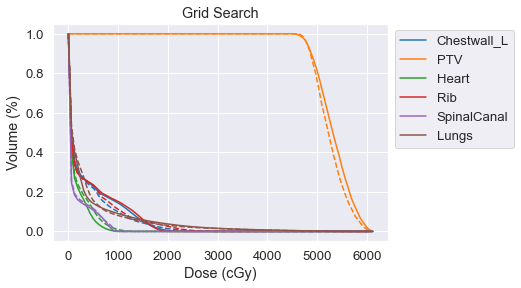

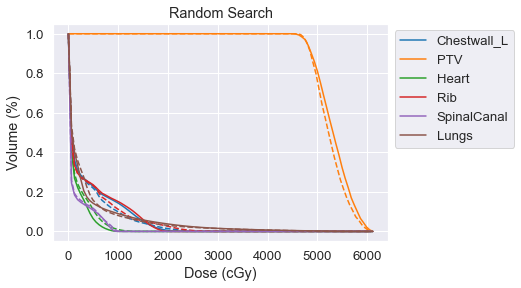

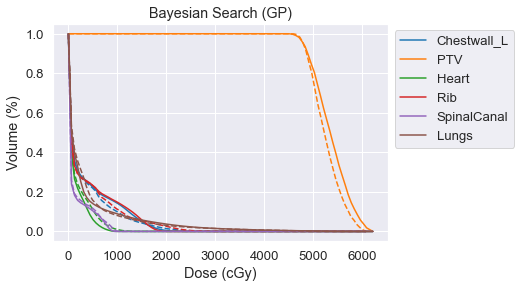

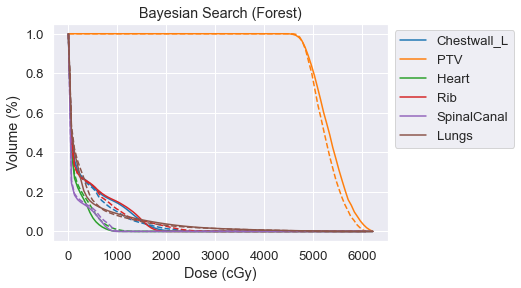

In [26]:
# Dose-volume histograms

from matplotlib import cm
colors = cm.tab10.colors

dvh_app = np.load('../approved/dvh.npy', allow_pickle=True).item()
dvh0 = np.load('dvh_0.npy', allow_pickle=True).item()
dvh1 = np.load('dvh_1.npy', allow_pickle=True).item()
dvh2 = np.load('dvh_2.npy', allow_pickle=True).item()
dvh3 = np.load('dvh_3.npy', allow_pickle=True).item()

def plot_dvh(dvh, title):
    plt.figure()
    roi_names = []
    handles = []
    idx = 0
    for roi in dvh.keys():
        if roi != 'Dose':
            handle, = plt.plot(dvh['Dose'], dvh[roi], color=colors[idx])
            plt.plot(dvh_app['Dose'], dvh_app[roi], '--', color=colors[idx])
            roi_names.append(roi)
            handles.append(handle)
            idx += 1
    plt.xlabel('Dose (cGy)')
    plt.ylabel('Volume (%)')
    plt.title(title)
    plt.legend(handles=handles, labels=roi_names, bbox_to_anchor=(1, 1))
    
plot_dvh(dvh0, 'Grid Search')
plot_dvh(dvh1, 'Random Search')
plot_dvh(dvh2, 'Bayesian Search (GP)')
plot_dvh(dvh3, 'Bayesian Search (Forest)')

In [27]:
# Compare goal results
res_names = ['GS', 'RS', 'GP', 'ET']

for goal, row in goals.iterrows():
    print(f"ROI: {row['Roi']}, Type: {row['Type']}")
    for idx, res in results.iterrows():
        level = row['AcceptanceLevel']
        diff_goal = 100*(res[goal] - level)/level
        app = results_approved[goal][0]
        diff_app = 100*(res[goal] - app)/app
        print(f'{res_names[idx]} Value: {res[goal]:.2f}, % Diff Goal: {diff_goal:.2f}, % Diff App: {diff_app:.2f}')
    print()

ROI: PTV, Type: MinDvh
GS Value: 4800.00, % Diff Goal: -0.00, % Diff App: -0.00
RS Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00
GP Value: 4800.00, % Diff Goal: -0.00, % Diff App: -0.00
ET Value: 4800.00, % Diff Goal: -0.00, % Diff App: -0.00

ROI: PTV, Type: MaxDose
GS Value: 6118.12, % Diff Goal: -1.95, % Diff App: 0.69
RS Value: 6112.94, % Diff Goal: -2.04, % Diff App: 0.61
GP Value: 6214.55, % Diff Goal: -0.41, % Diff App: 2.28
ET Value: 6216.89, % Diff Goal: -0.37, % Diff App: 2.32

ROI: SpinalCanal, Type: MaxDose
GS Value: 991.14, % Diff Goal: -52.35, % Diff App: -5.09
RS Value: 990.39, % Diff Goal: -52.39, % Diff App: -5.17
GP Value: 975.43, % Diff Goal: -53.10, % Diff App: -6.60
ET Value: 1006.17, % Diff Goal: -51.63, % Diff App: -3.65

ROI: Lungs, Type: MaxDvh
GS Value: 872.65, % Diff Goal: -56.37, % Diff App: 11.37
RS Value: 870.16, % Diff Goal: -56.49, % Diff App: 11.05
GP Value: 853.54, % Diff Goal: -57.32, % Diff App: 8.93
ET Value: 860.20, % Diff Goal: -56.99, % Di

In [ ]:
# The results for the approved plan are sometimes different from what I used here
# (MaxDose vs. MaxDvh in some cases...)

In [335]:
# Let's guess the shape of the surrogate functions at each iteration


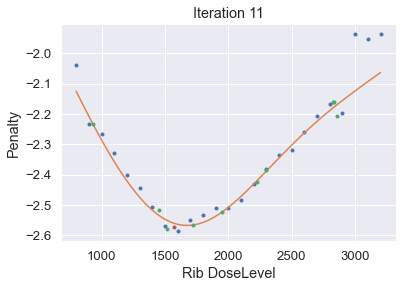

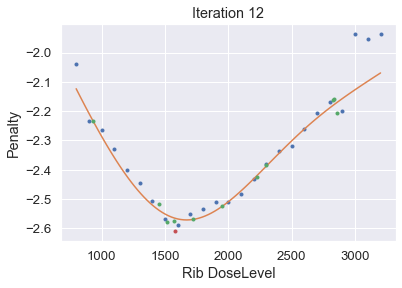

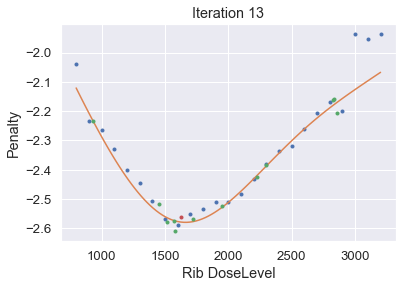

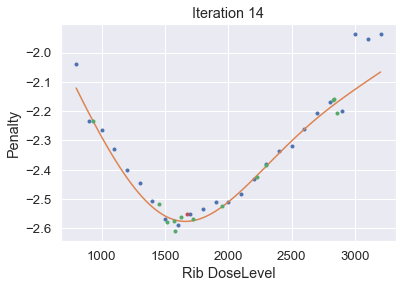

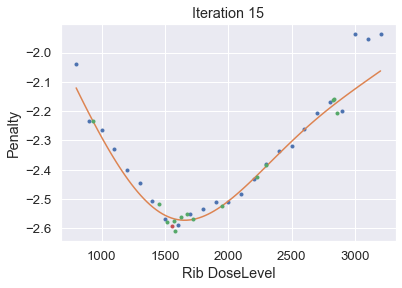

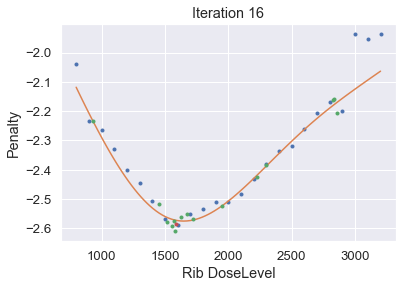

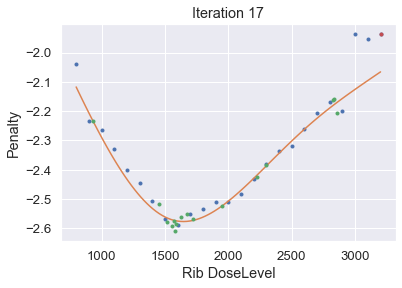

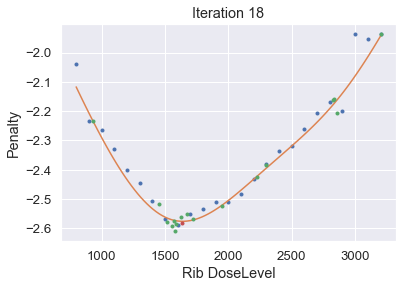

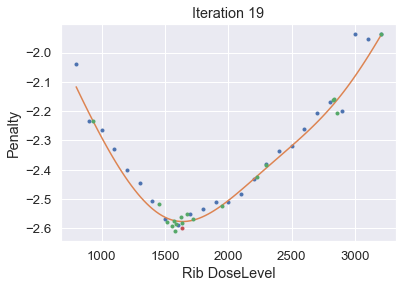

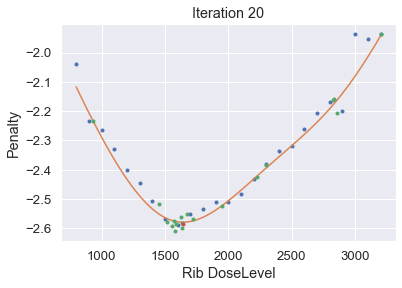

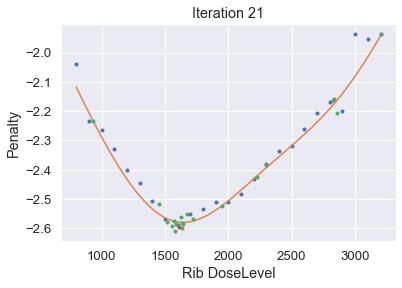

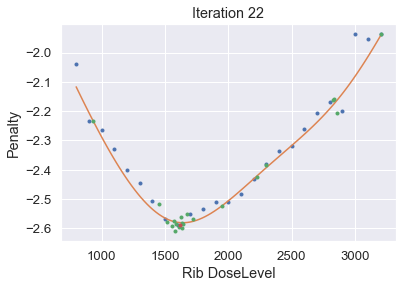

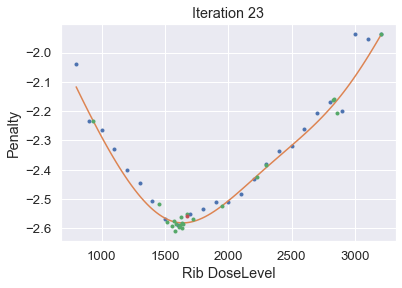

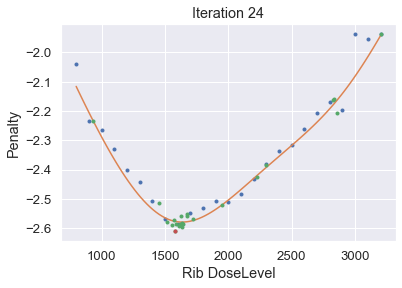

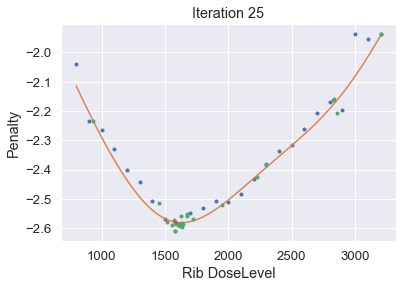

In [356]:
# Guassian Process

# Should save the surrogate models next time...
# It says the kernels are tuned, so can't assume it's what I've input

x_vals = np.linspace(800, 3200, 100)
for idx in range(10, 25):
    plt.figure()  
    plt.plot(x_grid, fun_grid, '.')
    model = gp.GaussianProcessRegressor(kernel=1**2 * gp.kernels.Matern(length_scale=1, nu=2.5) + gp.kernels.WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, random_state=209652396)
    model.fit(x_gp[:idx].reshape(-1, 1), fun_gp[:idx] )   
    y_vals = model.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_vals)
    plt.plot(x_gp[:idx], fun_gp[:idx], '.')
    plt.plot(x_gp[idx], fun_gp[idx], '.')
    plt.xlabel('Rib DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Iteration {idx+1}')

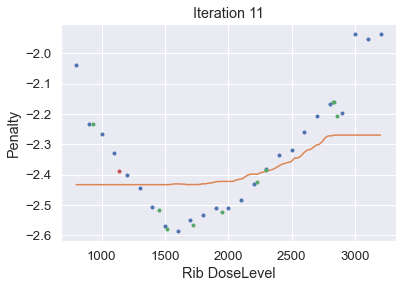

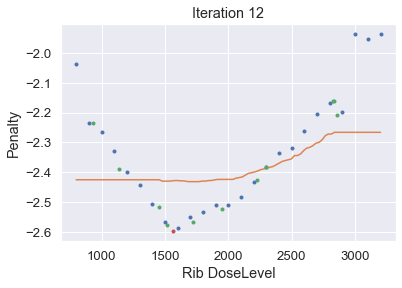

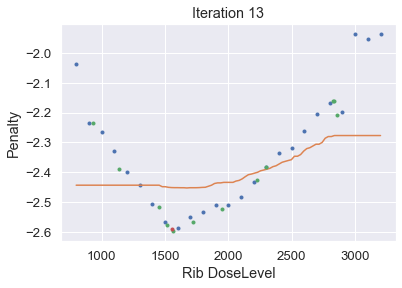

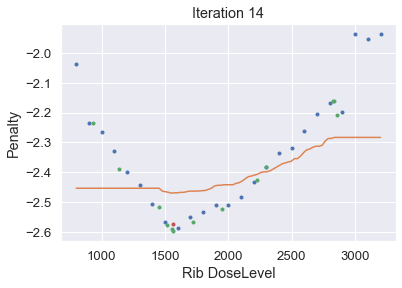

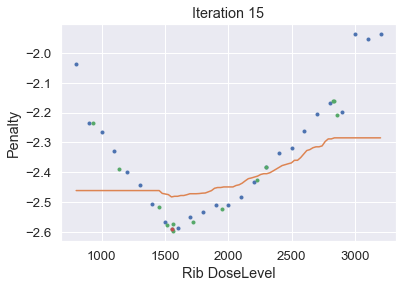

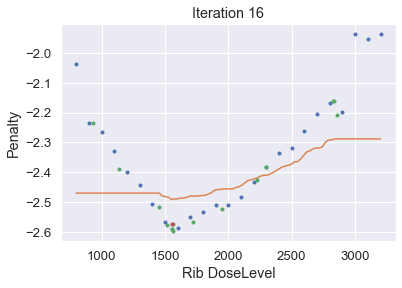

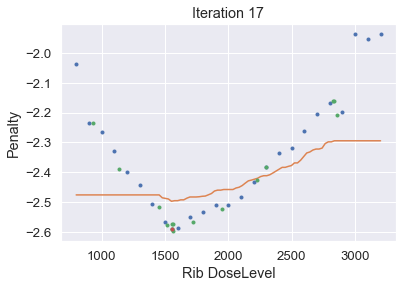

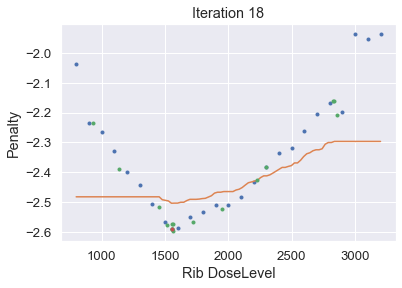

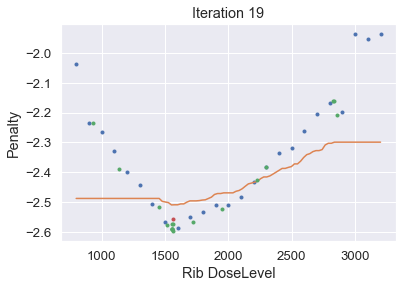

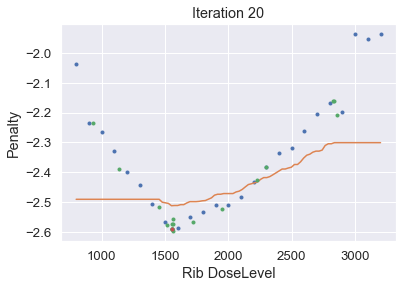

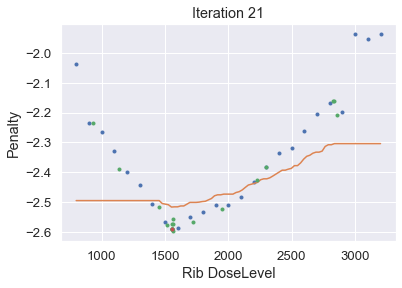

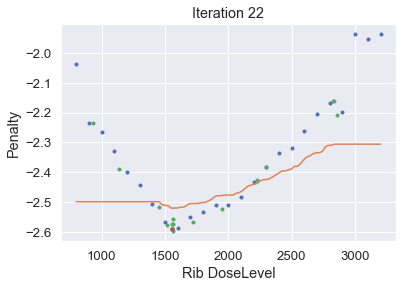

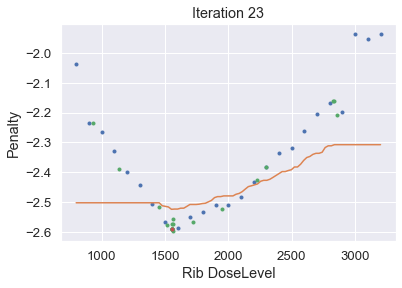

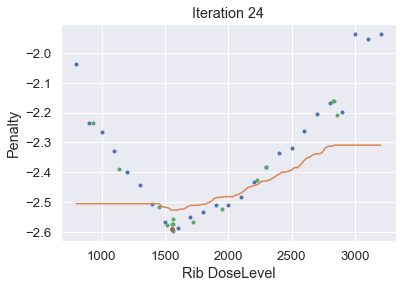

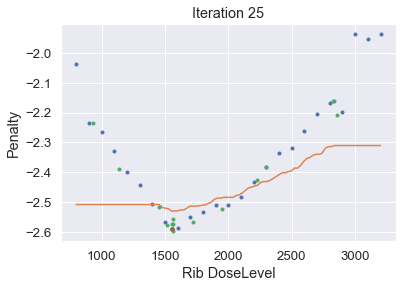

In [353]:
# Random Forest

# This looks terrible!

x_vals = np.linspace(800, 3200, 100)
for idx in range(10, 25):
    plt.figure()  
    plt.plot(x_grid, fun_grid, '.')
    model = ens.ExtraTreesRegressor(min_samples_leaf=3, n_estimators=100, random_state=209652396)
    model.fit(x_forest[:idx].reshape(-1, 1), fun_forest[:idx] )   
    y_vals = model.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_vals)
    plt.plot(x_forest[:idx], fun_forest[:idx], '.')
    plt.plot(x_forest[idx], fun_forest[idx], '.')
    plt.xlabel('Rib DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Iteration {idx+1}')